**Considere o schema abaixo:**

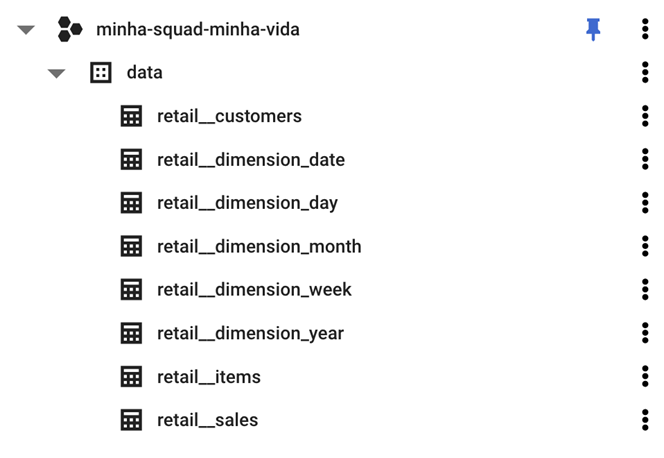

**1.	Construa um diagrama de entidade-relacionamento com as tabelas indicadas acima usando o https://dbdiagram.io/home;**

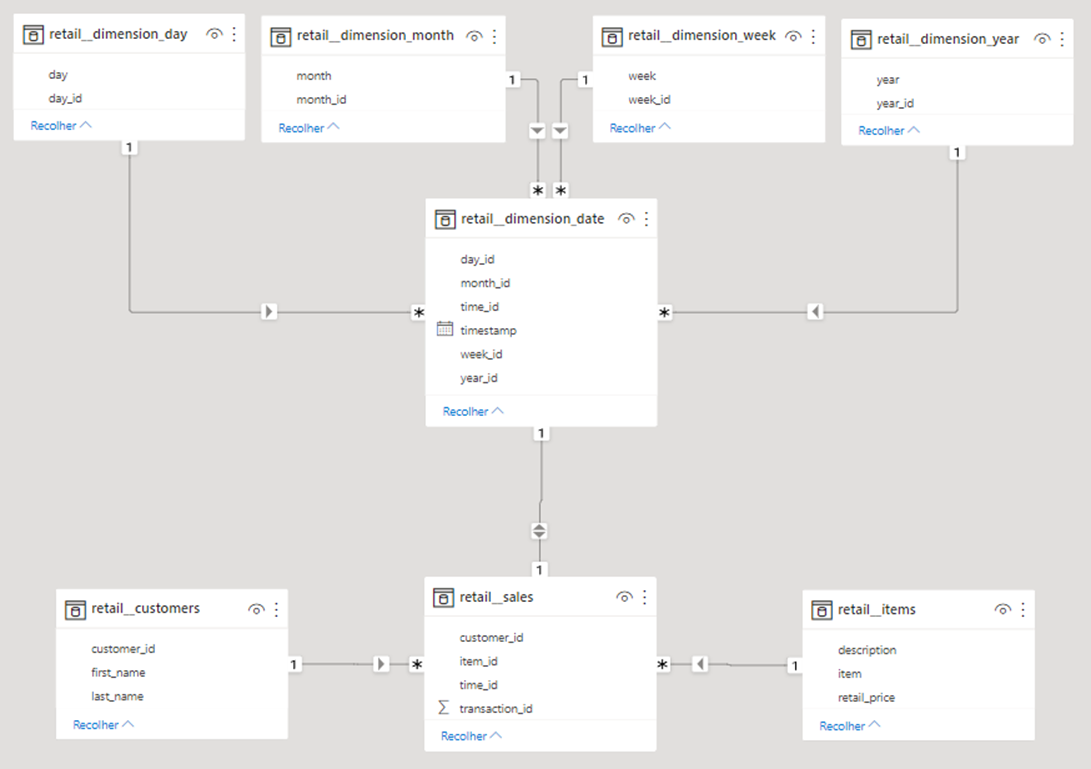

**2.	Qual o tipo de modelagem de dados usado nesse conjunto de dados? Explique seus conceitos.**

Trata-se de um sistema OLTP, focado na análise transacional de vendas em uma empresa. Este sistema é focado na performance de consulta e inserção de dados, sendo necessários tratamentos via query/modelo para uma melhor análise dos dados (OLAP).

A modelagem se encontra em sua terceira forma normal, com a categoria data sendo mais normalizada de modo a trazer maior performance para as consultas devido às SKs. Diante disso, têm-se um sistema Snow-flake, no qual há um relacionamento indireto entre a tabela de transações e as tabelas de segmentação temporal. 


In [ ]:
#3.	Construa um arquivo .sql que obtém o valor acumulado por mês para cada cliente
CREATE OR REPLACE TABLE roberto.desafio_04 AS(
WITH quantidade AS(
    SELECT 
        sl.customer_id, 
        it.item AS produto, 
        EXTRACT(MONTH FROM da.timestamp) AS mes,
        COUNT(EXTRACT(MONTH FROM da.timestamp)) AS quantidade_vendas,
    FROM 
        `minha-squad-minha-vida.data.retail__dimension_date` AS da,
        `minha-squad-minha-vida.data.retail__items` AS it,
        `minha-squad-minha-vida.data.retail__sales` AS sl  
    WHERE
        sl.time_id=da.time_id AND
        sl.item_id=it.item
    GROUP BY
        customer_id,
        produto, 
        mes
),
valor AS(
    SELECT
        customer_id,
        mes,
        SUM(ROUND(quantidade_vendas*it.retail_price,2)) AS vendas
    FROM
        quantidade,
        `minha-squad-minha-vida.data.retail__items` AS it
    WHERE
        produto=it.item
    GROUP BY
        customer_id,
        mes 
),
cliente AS(
    SELECT 
        DISTINCT (sl.customer_id)
    FROM 
        `minha-squad-minha-vida.data.retail__sales` AS sl
),
cliente_mes AS(
    SELECT 
        *
    FROM
        cliente, 
        UNNEST(GENERATE_ARRAY(1, 12)) AS month
    ORDER BY 
        customer_id
),
cliente_final AS(
SELECT
    cliente_mes.customer_id,
    cliente_mes.month,
    valor.vendas
FROM
    VALOR FULL OUTER JOIN 
    cliente_mes
    ON cliente_mes.customer_id = valor.customer_id AND
    cliente_mes.month = valor.mes
ORDER BY
    cliente_mes.customer_id,
    cliente_mes.month
),
ind AS (
    SELECT
        ROW_NUMBER() OVER()AS key,
        customer_id,
        month,
        IF(vendas IS NULL,0,vendas) as vendas
        
    FROM
        cliente_final
    ORDER BY
        customer_id,
        month
)
SELECT 
customer_id,
month,
#vendas,
ROUND(SUM(vendas) OVER (PARTITION BY customer_id ORDER BY key),2) AS vendas_acumuladas
FROM ind
ORDER BY
customer_id,
month
)



**4.	Proponha melhorias para esse conjunto de dados do Data Warehouse, considerando principalmente modelagem, usabilidade e performance. Apresente um diagrama de entidade-relacionamento com sua proposta;**

A relação de 1:1 entre a tabela dimensão data e vendas nos mostra que o banco de dados armazena apenas as datas em que determinada venda foi realizada. A solução, por mais que performática para o caso, afeta a evolução do banco de dados, uma vez que eventuais tabelas podem ser inseridas e precisem de outros intervalos temporais, como por exemplo o cruzamento de vendas com a saída temporal do estoque.

Sendo assim, propõe-se uma tabela dimensão de data compreendendo o timestamp mais antigo ao mais recente das tabelas fatos, levando a um relacionamento 1:N.

Podemos dizer que uma tabela se encontra na Terceira Forma Normal se está na segunda forma normal e se nenhum dos campos foram determinados transitivamente pela chave primária. Em tabela dimensão data já há uma terceira normalização, pois todas as colunas (ano, mês, dia, etc..) são exclusivamente dependentes de apenas uma referência, o timestamp.

Sendo assim, a normalização destas colunas não traz melhorias em relação ao modelo de dados. Todavia, há um ganho de performance ao substituir as informações presentes nas datas por SKs que demandam menos espaço de memória, otimizando a consulta.

A partir do exposto, ponderando as vantagens e desvantagens de cada proposta, propõe-se um star-schema, removendo as tabelas dimensão year, month, day, week, pois trazem pouco ganho performático, e cria-se uma tabela dimensão data completa, mantendo a SK time_id de modo que a relação com a tabela vendas não seja feita com a timestamp, coluna esta que armazena grande quantidade de informações (alto armazenamento). 

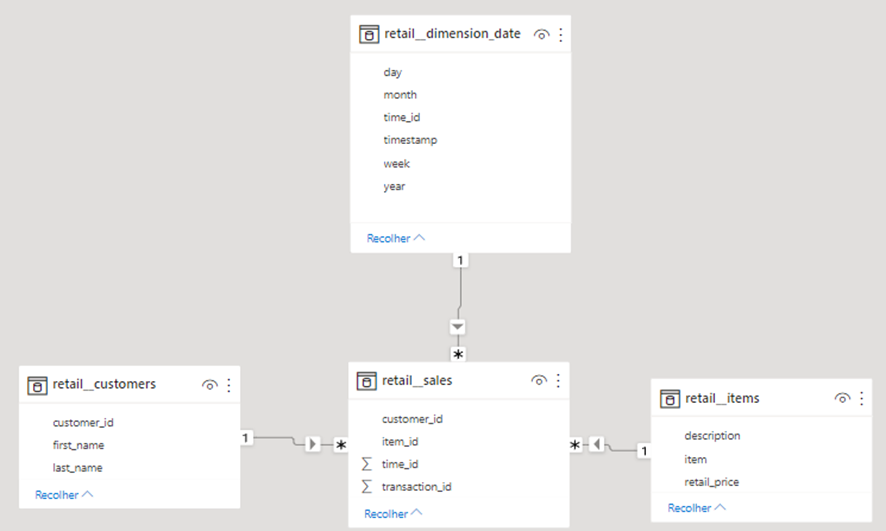

**5.	Considere o dashboard Retail, apresentado abaixo, o qual consome os dados do conjunto de dados anterior:**

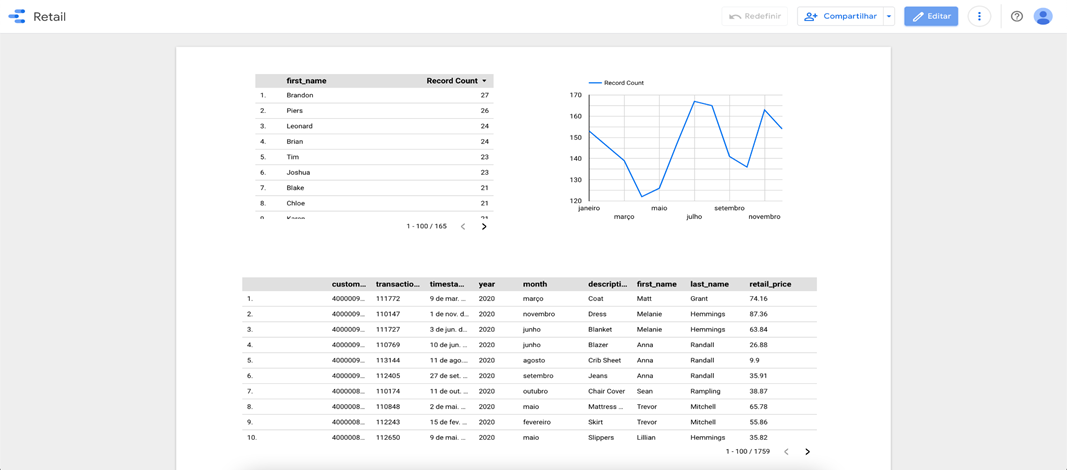


**6.	Proponha um plano de migração para o Data Warehouse, de modo que a modelagem siga a sua proposta, feita anteriormente. Considere todos os problemas que possam surgir nesse processo de migração;**

As modificações propostas se resumem em:
- Remoção das tabelas year, month, week, day;
- Criação de uma tabela dimensão com todas as datas no intervalo de análise.

A remoção das tabelas apresentadas acima pode afetar eventuais consultas vinculadas a elas. Sendo assim, propõe-se primeiramente a criação da nova tabela data, de modo que estas consultas possam se adequar à informação agora contida nesta nova tabela. Estas novas consultas podem ser feitas transformando as SKs no respectivo mês, dia, ano e semana que elas representam. Desta forma é possível criar um novo relacionamento e excluir as tabelas antigas.

A relação entre a nova tabela data e a tabela fato pode ser feita sem nenhum impacto no modelo, uma vez que, no sistema proposto, é mantido a SK time_id. Sendo assim, faz-se necessário apenas a remoção da tabela antiga pela nova.

**7.	Proponha métricas separadas por categoria que possam prover insights sobre o conjunto de dados. Quais dados adicionais você gostaria de ter acesso para análises mais profundas?**

Com os valores de vendas e suas respectivas datas podemos determinar evoluções temporais da empresa com indicadores importantes como YoY (year over year) e MoM (month over month).

Com o número de vendas e valor total de vendas por cliente é possível determinar o perfil que mais performa na empresa, sendo assim propostas mais agressivas de marketing poderiam escalar ainda mais a receita. 

Da mesma forma, perfis que compram com recorrência, que demonstram fidelidade à empresa, mas apresentam baixo valor final de venda, também podem ser estimulados de forma a terem melhor performance, como iniciativa temos, por exemplo, oferecimento de cupons de desconto. 

Pode-se também determinar o importantíssimo indicador churn de clientes (taxa de cancelamento), desta forma a empresa se prepara para adotar medidas que mitiguem o abandono de clientes.
A análise performática dos produtos ao longo dos anos também direciona a empresa a ações importantes como focar em determinada linha de produtos, adequação do ticket médio ou atém mesmo o abandono de produtos pouco performáticos mesmo diante de investimento financeiro.

Em relação a dados adicionais, como dito anteriormente, é salutar o armazenamento de informações de estoque e entrega de produtos. Desta forma, o cruzamento entre vendas e estes novos dados dá ao gestor controle sobre potenciais produtos que podem faltar, que estão com prazo de validade curto ou que estão com fornecimento atrasado. Além disso, pode-se proporcionar uma linha temporal de toda a cadeia de produção, por exemplo, caso uma venda on-line tenha sido feita e o estoque tenha despachado no mesmo dia, mas a data de entrega tenha sido bem acima do esperado, pelo cruzamento dos dados fica evidente para o gestor que o setor de transporte precisa ser trabalhado.

